In [158]:
import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths

import torch

import pandas as pd

from src.utils import plot_embeddings, plot_confusion_matrix, performance_metrics, ms_label2id, ms_id2label, load_ms_data

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [159]:
def show_results(file_name: str, plot_hidden_states = True) -> None:
    results = torch.load(paths.RESULTS_PATH / "ms-diag" / f"{file_name}")
    
    labels = [ms_id2label[label] for label in results["labels"]]
    preds = [ms_id2label[pred] for pred in results["preds"]]

    # Plot confusion matrix
    plot_confusion_matrix(preds=preds, labels=labels, title=file_name)
    plt.show()

    # Plot embeddings
    if plot_hidden_states:
        # Last hidden states is a list of tensors of shape (seq_len, hidden_size)
        last_hidden_state = [batch[0, :] for batch in results["last_hidden_state"]]  # Use CLS token
        embeddings = torch.stack(last_hidden_state, dim=0).to(torch.float16)
        plot_embeddings(embeddings=embeddings, labels=labels, title=file_name)
        plt.show()

    # Print classification report
    print(classification_report(y_true=labels, y_pred=preds), "\n\n")

    # Show all wrongly classified samples
    for i in range(len(labels)):
        if labels[i] != preds[i]:
            print(f"Label: {labels[i]} - Prediction: {preds[i]}")
            print(results["text"][i])
            # Print the probabilities for each class by converting the logits to probabilities, then rounding them
            print("Probabilities:", dict(zip(ms_label2id.keys(), [round(prob, 3) for prob in torch.softmax(torch.tensor(results["logits"][i]), dim=0).numpy()])), "\n\n")

# MedBERT 512

## Strategy: Classify on single lines, 4 Labels (including no MS) and oversampling for training

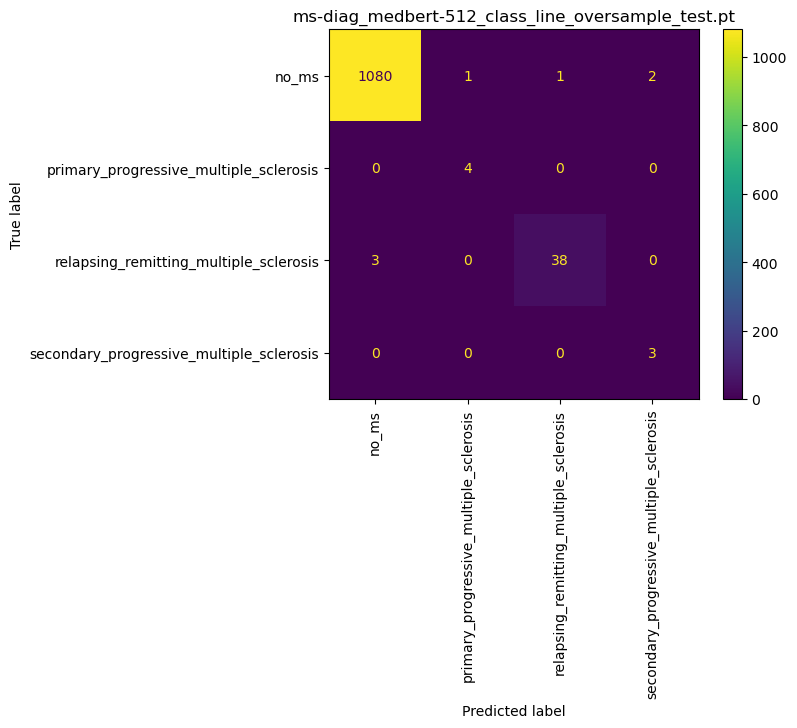

(1132, 2)


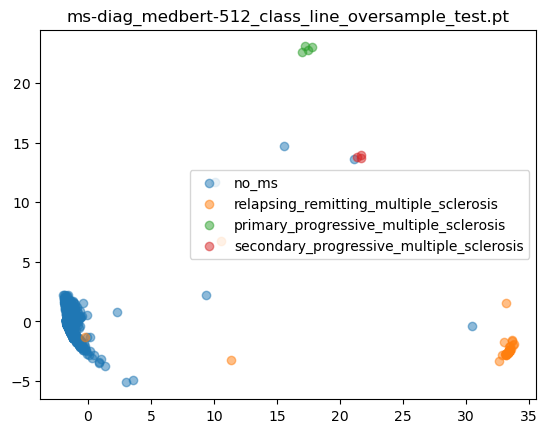

                                          precision    recall  f1-score   support

                                   no_ms       1.00      1.00      1.00      1084
  primary_progressive_multiple_sclerosis       0.80      1.00      0.89         4
  relapsing_remitting_multiple_sclerosis       0.97      0.93      0.95        41
secondary_progressive_multiple_sclerosis       0.60      1.00      0.75         3

                                accuracy                           0.99      1132
                               macro avg       0.84      0.98      0.90      1132
                            weighted avg       0.99      0.99      0.99      1132
 


Label: no_ms - Prediction: secondary_progressive_multiple_sclerosis
DD sekundär progredienter Verlauf mit aufgesetzten Schüben
Probabilities: {'primary_progressive_multiple_sclerosis': 0.0, 'relapsing_remitting_multiple_sclerosis': 0.007, 'secondary_progressive_multiple_sclerosis': 0.992, 'no_ms': 0.0} 


Label: no_ms - Prediction: rela

In [160]:
show_results("ms-diag_medbert-512_class_line_oversample_test.pt")

In [208]:
# Changing format of line labelled to aggregated text predictions

result = torch.load(paths.RESULTS_PATH / "ms-diag" / "ms-diag_medbert-512_class_line_oversample_test.pt")
# Creat DF from rid, pred, label, text
df = pd.DataFrame({"rid": result["rid"], "preds": result["preds"], 
                   "labels": result["labels"], "text": result["text"], 
                   "logits": result["logits"], "last_hidden_state": result["last_hidden_state"]})

# All rids that have at least one prediction other than 3 (no MS)
df_list = []

for i, rid_data in df.groupby("rid"):
    # Get most frequent prediction from classes [0, 1, 2]
    _df = {}
    if rid_data["preds"].value_counts().index[0] == 3 and len(rid_data["preds"].value_counts()) > 1:
        class_idx = rid_data["preds"].value_counts().index[1]
        lines_of_interest = rid_data[rid_data["preds"] == class_idx]
        _df["preds"] = class_idx
        _df["logits"] = [sum(logits) / len(logits) for logits in zip(*lines_of_interest["logits"].tolist())]
        # Take first token of last hidden state
        last_hidden_state = torch.stack([batch[0, :] for batch in lines_of_interest["last_hidden_state"].tolist()], dim = 0)
        _df["last_hidden_state"] = last_hidden_state.mean(dim=0).view(1, -1)
    else:
        class_idx = 3
        lines_of_interest = rid_data[rid_data["preds"] == class_idx]
        _df["preds"] = class_idx
        _df["logits"] = [sum(logits) / len(logits) for logits in zip(*lines_of_interest["logits"].tolist())]
        # Take first token of last hidden state
        last_hidden_state = torch.stack([batch[0, :] for batch in lines_of_interest["last_hidden_state"].tolist()], dim = 0)
        _df["last_hidden_state"] = last_hidden_state.mean(dim=0).view(1, -1)
    
    if rid_data["labels"].value_counts().index[0] == 3 and len(rid_data["labels"].value_counts()) > 1:
        _df["labels"] = rid_data["labels"].value_counts().index[1]
    else:
        _df["labels"] = 3
    _df["rid"] = i
    _df["text"] = "\n".join(rid_data["text"].tolist())

    df_list.append(_df)

df_agg = pd.DataFrame(df_list)
torch.save(df_agg.to_dict("list"), paths.RESULTS_PATH / "ms-diag" / "ms-diag_medbert-512_class_line_oversample_test_agg.pt")

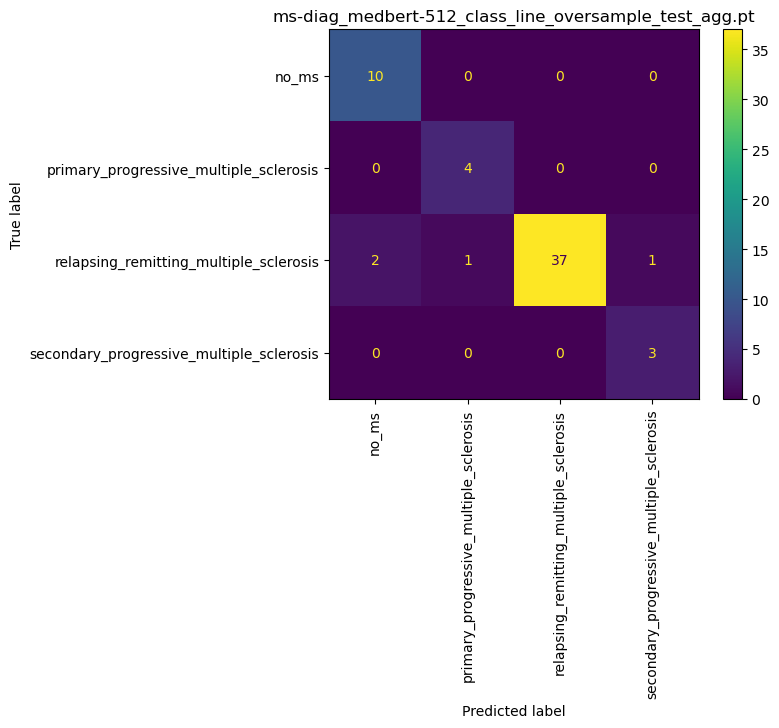

(58, 2)


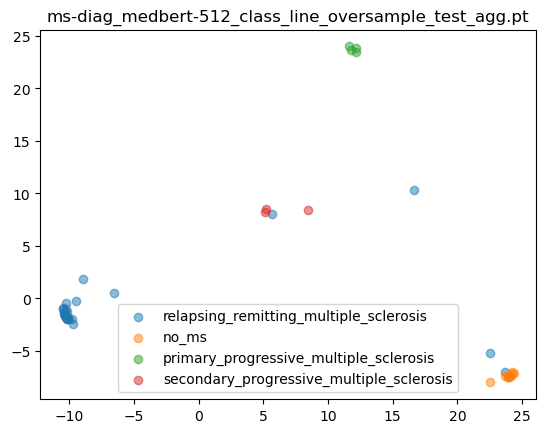

                                          precision    recall  f1-score   support

                                   no_ms       0.83      1.00      0.91        10
  primary_progressive_multiple_sclerosis       0.80      1.00      0.89         4
  relapsing_remitting_multiple_sclerosis       1.00      0.90      0.95        41
secondary_progressive_multiple_sclerosis       0.75      1.00      0.86         3

                                accuracy                           0.93        58
                               macro avg       0.85      0.98      0.90        58
                            weighted avg       0.94      0.93      0.93        58
 


Label: relapsing_remitting_multiple_sclerosis - Prediction: no_ms
INDENT mit Progression der intracerebralen bihemisphärischen Raumforderungen, ED 22.09.2020
INDENT anamnestisch: Armschwäche rechts seit dem 25.08.2020, nach initialer Besserung der Symptomatik erneute Verschlechterung seit dem 22.09.2020. 
INDENT klinisch: 
INDENT Leicht

In [210]:
show_results("ms-diag_medbert-512_class_line_oversample_test_agg.pt", plot_hidden_states=True)

The bad precision stems from the fact the we have an imbalanced dataset. Even though only 4 RRMS get classified wrong, it makes a huge difference for the precision of PPMS and SPMS as there are only so few examples.

## Strategy: Classify on single lines, 3 Labels (original approach with only dm samples) and oversampling for training

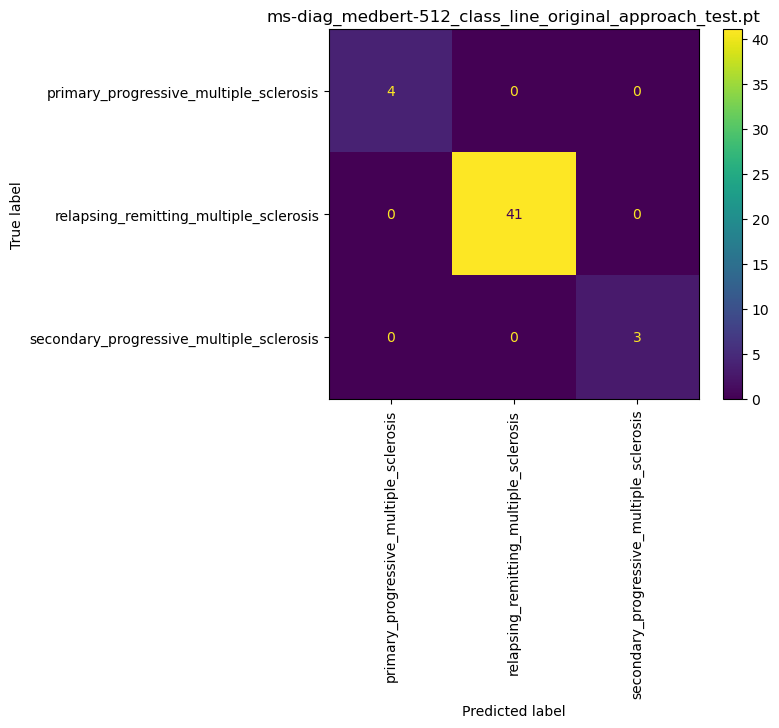

(48, 2)


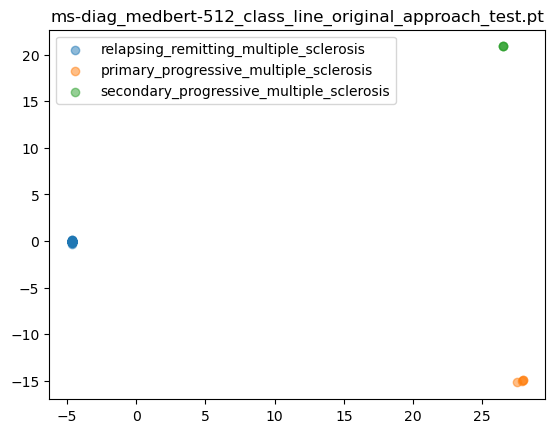

                                          precision    recall  f1-score   support

  primary_progressive_multiple_sclerosis       1.00      1.00      1.00         4
  relapsing_remitting_multiple_sclerosis       1.00      1.00      1.00        41
secondary_progressive_multiple_sclerosis       1.00      1.00      1.00         3

                                accuracy                           1.00        48
                               macro avg       1.00      1.00      1.00        48
                            weighted avg       1.00      1.00      1.00        48
 




In [216]:
show_results("ms-diag_medbert-512_class_line_original_approach_test.pt")

## Strategy: Classify on whole report, 4 labels (including no ms) training on oversampled

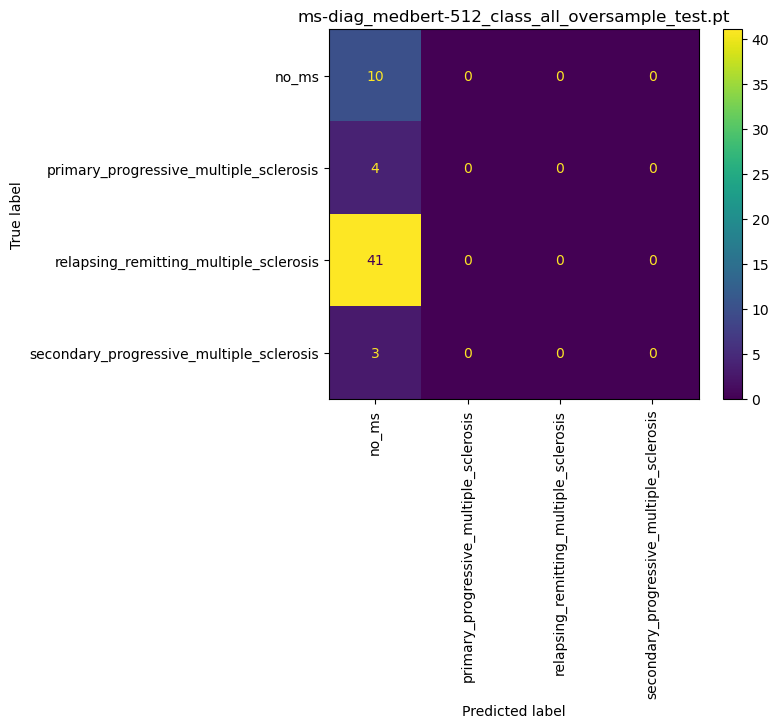

(58, 2)


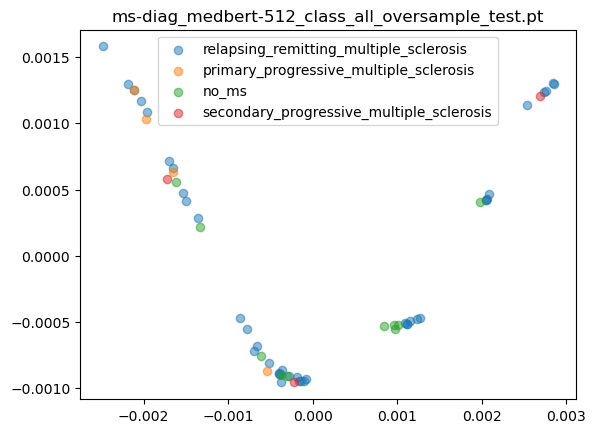

                                          precision    recall  f1-score   support

                                   no_ms       0.17      1.00      0.29        10
  primary_progressive_multiple_sclerosis       0.00      0.00      0.00         4
  relapsing_remitting_multiple_sclerosis       0.00      0.00      0.00        41
secondary_progressive_multiple_sclerosis       0.00      0.00      0.00         3

                                accuracy                           0.17        58
                               macro avg       0.04      0.25      0.07        58
                            weighted avg       0.03      0.17      0.05        58
 


Label: relapsing_remitting_multiple_sclerosis - Prediction: no_ms
Schubförmige Multiple Sklerose, EM 1997, ED 1/2013, EDSS 0.0
Aktuell/klinisch: beschwerdefrei bis auf minime Pallhypästhesie aller 4 Extremitäten 7/8
Verlauf:
INDENT - 1997 Visusstörung Auge rechts, seither unverändert (anamnestisch)
INDENT - 01/2013 Episode mit Hypästhes

/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [215]:
show_results("ms-diag_medbert-512_class_all_oversample_test.pt")

## Strategy: Classify on whole report, 3 Labels (original approach with only reports containing at least one dm line), oversampling for training

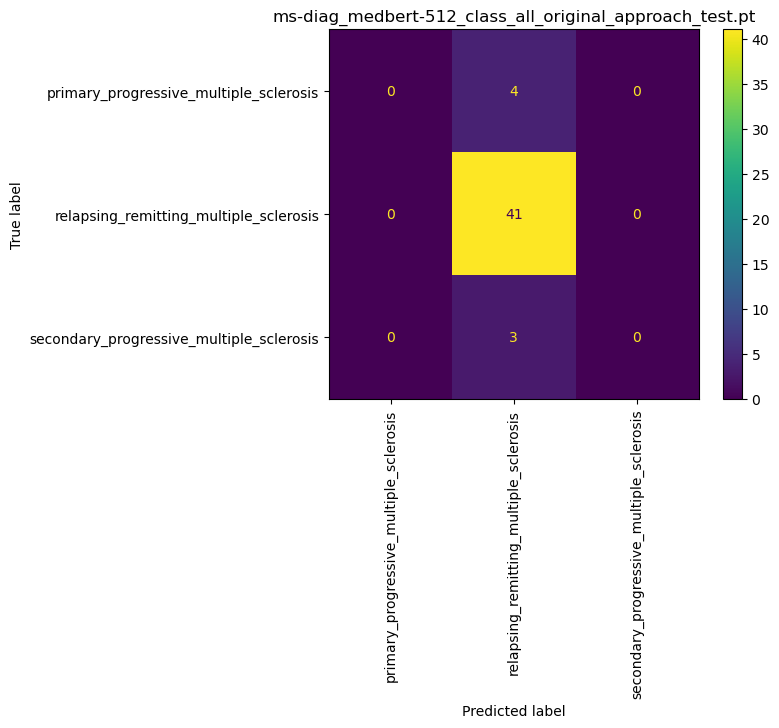

(48, 2)


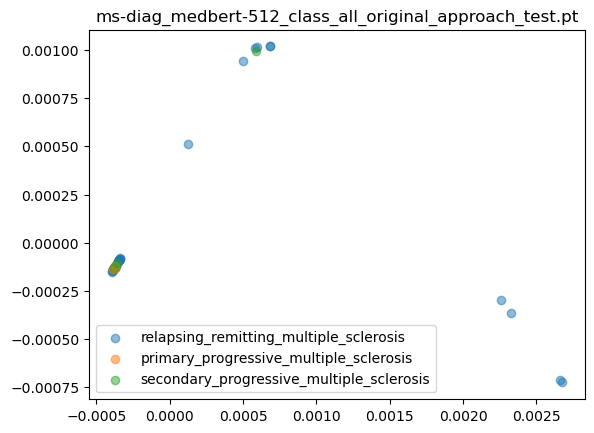

                                          precision    recall  f1-score   support

  primary_progressive_multiple_sclerosis       0.00      0.00      0.00         4
  relapsing_remitting_multiple_sclerosis       0.85      1.00      0.92        41
secondary_progressive_multiple_sclerosis       0.00      0.00      0.00         3

                                accuracy                           0.85        48
                               macro avg       0.28      0.33      0.31        48
                            weighted avg       0.73      0.85      0.79        48
 


Label: primary_progressive_multiple_sclerosis - Prediction: relapsing_remitting_multiple_sclerosis
1. Multiple Sklerose, a.e. primär-progredient, DD aufgelagerte Schübe (EM 2008, ED 11/2011), EDSS 6.0
Aktuell: klinisch nicht aktiv, radiologisch fraglich aktiv (DD technisch bedingt), keine Progression (nach Lublin et al. 2013)
Verlauf:
INDENT 2008: Lhermitte-Zeichen mit elektrischer Sensation vom Hals bis in das linke

/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [214]:
show_results("ms-diag_medbert-512_class_all_original_approach_test.pt")